## `Imports:`

In [47]:
import datetime
import time
import os 
import subprocess
import numpy as np
import pandas as pd
from mygene import MyGeneInfo
import gseapy as gp
import matplotlib.pyplot as plt

## `Prepare Data for FGSEA (Hallmark Gene Sets):`

In [42]:
## -------------------------------------------------------------------------------------------
# PREPARE DATA:

# specify data directory ------
dir = '../../twas_toolbox/data/'

# probe.manifest data  -------------------------------------------------------------------
# load the probe manifest file --------
probe_manifest = pd.read_csv(dir + 'probe.manifest.txt', sep='\t', index_col=0)

# display the first few rows of the probe manifest file ------
display(probe_manifest.head())
print(probe_manifest.columns)
print(probe_manifest.shape)

# gene expression data -------------------------------------------------------------------
# load the gene expression data ------
naive_exp = pd.read_csv(dir + 'CD14.47231.414.b.txt', sep='\t', index_col=0)
lps2_exp = pd.read_csv(dir + 'LPS2.47231.261.b.txt', sep='\t', index_col=0)

print('raw exp data contains {} rows and {} columns'.format(naive_exp.shape[0], naive_exp.shape[1]))

# filter rows of raw expression data for QC'ed probes -----
naive_exp = naive_exp.loc[naive_exp.index.isin(probe_manifest['probe'])]
lps2_exp = lps2_exp.loc[lps2_exp.index.isin(probe_manifest['probe'])]

# Append suffixes to the column names to distinguish the states
naive_exp.columns = [col + '_naive' for col in naive_exp.columns]
lps2_exp.columns = [col + '_lps2' for col in lps2_exp.columns]

# combine gene expression data -------------------------------------
combined_exp = pd.concat([naive_exp, lps2_exp], axis=1)
probe_manifest.set_index('probe', inplace=True)
combined_exp.index = combined_exp.index.map(probe_manifest['hgnc_symbol'])
combined_exp = combined_exp[combined_exp.index.notna()]

# Create a list of phenotype labels ('naive' or 'LPS2')
phenotypes = ['naive'] * naive_exp.shape[1] + ['lps2'] * lps2_exp.shape[1]

# display --------
display(combined_exp.head())
display(combined_exp.shape)
print(phenotypes[:5])

,hgnc_symbol,gene_type,chromosome,gene.genome.start,gene.genome.stop,transcript.id,probe,ProbeSequence,match,probe.genome.start,...,transcript.end,naive.var,naive.avg,lps2.var,lps2.avg,lps24.var,lps24.avg,ifn.var,ifn.avg,var.across.trxs
gene.id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232,WASH7P,pseudogene,1,14363,29806,ENST00000488147,ILMN_3239735,CAGGGAAGTGGTTGACCCCTCCGGTGGCTGGCCACTCTGCTAGAGT...,50,15885,...,1130,0.059468,7.923896,0.066340,7.775906,0.048774,7.874820,0.066776,7.934684,0.005250
ENSG00000229376,CICP3,pseudogene,1,657472,660283,ENST00000440782,ILMN_3240023,ACATGGCCAGCGAGGTCATAGCGAGTGACGAGGAGCACACGGTCAT...,50,658684,...,1262,0.002425,7.049052,0.002947,7.047352,0.003116,7.043778,0.002514,7.039310,0.000019
ENSG00000187634,SAMD11,protein_coding,1,860260,879955,ENST00000455979,ILMN_2195138,TATGCCGTCAGCCCCTACTTCCACACAGGCGCGGTAGGGGGACTCT...,50,878411,...,1066,0.010082,7.258857,0.026831,7.326608,0.009034,7.272301,0.007154,7.284213,0.000859
ENSG00000188976,NOC2L,protein_coding,1,879584,894689,ENST00000483767,ILMN_1792820,GAGAGGGATACTGAGGCCCCTGAGCACTCGGCATGGGGTGGAAGAC...,50,880898,...,954,0.017841,7.439386,0.036304,7.467359,0.010867,7.385250,0.017797,7.551393,0.004805
ENSG00000187961,KLHL17,protein_coding,1,895967,901095,ENST00000338591,ILMN_1705602,AGTGCCACGGCTGCCCGTTTACACCTTTAGCGTCTGGTCCTCCTGC...,50,900738,...,2255,0.019501,7.136000,0.025914,7.083890,0.044771,7.209478,0.015465,7.093127,0.003279


Index(['hgnc_symbol', 'gene_type', 'chromosome', 'gene.genome.start',
       'gene.genome.stop', 'transcript.id', 'probe', 'ProbeSequence', 'match',
       'probe.genome.start', 'probe.genome.stop', 'probe.genome.strand',
       'transcript.size', 'transcript.start', 'transcript.end', 'naive.var',
       'naive.avg', 'lps2.var', 'lps2.avg', 'lps24.var', 'lps24.avg',
       'ifn.var', 'ifn.avg', 'var.across.trxs'],
      dtype='object')
(18183, 24)
raw exp data contains 47231 rows and 414 columns


,1_naive,2_naive,3_naive,4_naive,5_naive,6_naive,7_naive,8_naive,9_naive,10_naive,...,423_lps2,424_lps2,425_lps2,426_lps2,427_lps2,428_lps2,429_lps2,430_lps2,431_lps2,432_lps2
PROBE_ID,,,,,,,,,,,,,,,,,,,,,
RERE,9.550713,9.790441,8.923455,9.604683,9.484594,9.523939,9.083036,9.592191,9.515965,9.712605,...,8.591713,8.442648,8.756818,8.535602,8.719903,8.116286,8.458417,8.400325,8.713031,8.517230
RNF165,7.136265,7.091600,7.242814,7.236313,7.061778,7.239694,7.225508,7.165777,7.352366,7.376674,...,7.123135,7.622109,7.114724,7.169063,7.128923,7.391938,7.081988,7.053981,7.141335,7.233534
DLEC1,7.079553,7.105109,7.230288,7.070668,7.216422,7.099107,7.350692,7.076485,7.425835,7.293771,...,7.086891,7.410210,7.210988,7.177680,7.067776,7.237304,7.296183,7.146097,7.145490,7.147350
PHF7,7.332784,7.300656,7.284492,7.143190,7.169019,7.435675,7.304099,7.298730,7.327327,7.546383,...,7.111267,6.943411,7.074668,7.285498,7.219530,7.179615,7.102556,6.913069,6.957159,7.291697
TBC1D29P,7.167123,7.070423,7.187184,7.117254,7.096269,7.315210,7.040831,7.151768,7.201262,7.191588,...,7.051897,7.114835,7.253061,7.015709,7.080821,7.020425,7.367544,7.338165,7.342472,7.259711


(17719, 675)

['naive', 'naive', 'naive', 'naive', 'naive']


## `Perform FGSEA:`

In [43]:
# Run GSEA
gsea_results = gp.gsea(data=combined_exp,  
                       gene_sets=dir + 'h.all.v7.2.symbols.gmt',
                       cls=phenotypes,        # List of classes corresponding to samples
                       permutation_num=1000,  # Number of permutations
                       min_size=15,
                       max_size=500,
                       seed=6)                # Seed for reproducibility

# Display results
gsea_results.res2d.head()

2024-04-29 14:38:25,629 [WARNING] Found duplicated gene names, values averaged by gene names!
/home/yim2/.local/lib/python3.11/site-packages/gseapy/gsea.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_COMPLEMENT,-0.60866,-2.498347,0.0,0.0,0.0,69/184,16.33%,CXCL1;EHD1;DUSP5;IL6;IRF1;CCL5;MAFF;OLR1;TNFAI...
1,gsea,HALLMARK_IL6_JAK_STAT3_SIGNALING,-0.665035,-2.412082,0.0,0.0,0.0,27/75,8.09%,CXCL1;IL1B;IL6;IRF1;MAP3K8;SOCS1;SOCS3;PTPN1;C...
2,gsea,HALLMARK_KRAS_SIGNALING_UP,-0.567662,-2.380584,0.0,0.0,0.0,56/179,14.96%,CCL20;IL1B;PTGS2;BIRC3;TRAF1;TNFAIP3;USP12;IL7...
3,gsea,HALLMARK_HYPOXIA,-0.560233,-2.379979,0.0,0.0,0.0,67/179,13.92%,NOCT;IL6;SDC4;ISG20;MAFF;TNFAIP3;AMPD3;DUSP1;P...
4,gsea,HALLMARK_IL2_STAT5_SIGNALING,-0.5892,-2.358211,0.0,0.0,0.0,72/182,12.63%,NFKBIZ;MAP3K8;SOCS1;TNFRSF9;MAFF;TRAF1;DENND5A...


In [45]:
gsea_results.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_COMPLEMENT,-0.60866,-2.498347,0.0,0.0,0.0,69/184,16.33%,CXCL1;EHD1;DUSP5;IL6;IRF1;CCL5;MAFF;OLR1;TNFAI...
1,gsea,HALLMARK_IL6_JAK_STAT3_SIGNALING,-0.665035,-2.412082,0.0,0.0,0.0,27/75,8.09%,CXCL1;IL1B;IL6;IRF1;MAP3K8;SOCS1;SOCS3;PTPN1;C...
2,gsea,HALLMARK_KRAS_SIGNALING_UP,-0.567662,-2.380584,0.0,0.0,0.0,56/179,14.96%,CCL20;IL1B;PTGS2;BIRC3;TRAF1;TNFAIP3;USP12;IL7...
3,gsea,HALLMARK_HYPOXIA,-0.560233,-2.379979,0.0,0.0,0.0,67/179,13.92%,NOCT;IL6;SDC4;ISG20;MAFF;TNFAIP3;AMPD3;DUSP1;P...
4,gsea,HALLMARK_IL2_STAT5_SIGNALING,-0.5892,-2.358211,0.0,0.0,0.0,72/182,12.63%,NFKBIZ;MAP3K8;SOCS1;TNFRSF9;MAFF;TRAF1;DENND5A...
5,gsea,HALLMARK_APOPTOSIS,-0.567278,-2.354222,0.0,0.0,0.0,52/144,11.77%,IL1A;IL1B;GCH1;BTG3;IL6;IRF1;PMAIP1;BIRC3;ISG2...
6,gsea,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-0.579953,-2.354008,0.0,0.0,0.0,61/183,16.80%,CXCL1;IL6;SDC4;TNFAIP3;CXCL8;ITGA5;CD44;GADD45...
7,gsea,HALLMARK_INFLAMMATORY_RESPONSE,-0.836029,-2.262385,0.0,0.0,0.0,109/185,8.99%,CCL20;IL1A;IRAK2;NFKB1;IL1B;GCH1;TNFAIP6;IL6;I...
8,gsea,HALLMARK_COAGULATION,-0.519335,-2.146628,0.0,0.000161,0.001,33/124,17.21%,MAFF;OLR1;F3;SERPINB2;PLEK;PDGFB;CAPN2;MMP14;S...
9,gsea,HALLMARK_HEDGEHOG_SIGNALING,-0.662475,-2.142228,0.0,0.000145,0.001,7/31,6.28%,NRP2;PML;ETS2;HEY1;TLE1;CDK6;MYH9


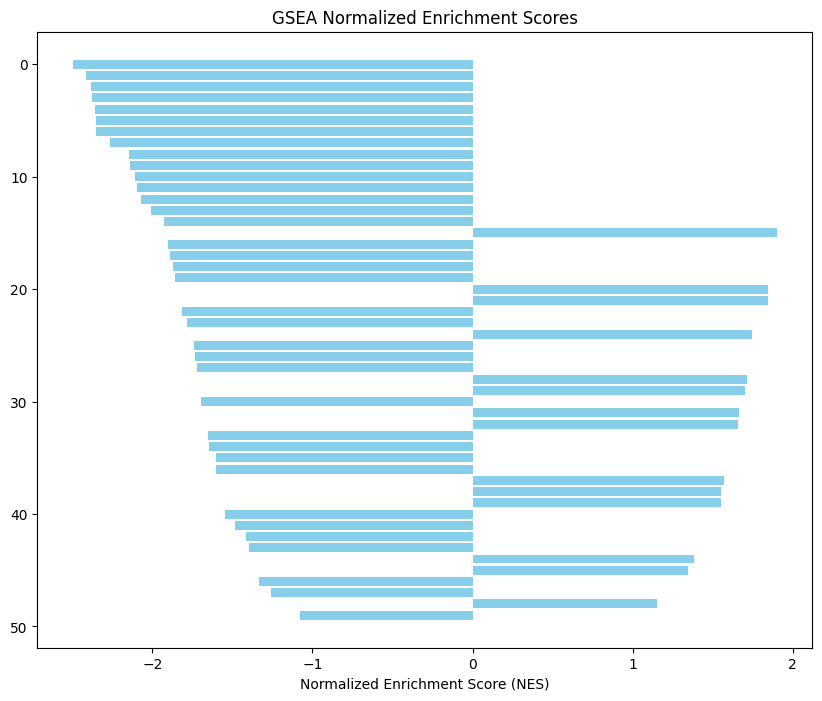

In [49]:
nes = gsea_results.res2d['NES']
genesets = gsea_results.res2d.index

plt.figure(figsize=(10, 8))
plt.barh(genesets, nes, color='skyblue')
plt.xlabel('Normalized Enrichment Score (NES)')
plt.title('GSEA Normalized Enrichment Scores')
plt.gca().invert_yaxis() 
plt.show()

# `Developing Pathway Activation Score:`

In [53]:
## -------------------------------------------------------------------------------------------
# CREATE CORRELATION MATRIX FROM GENE EXPRESSION DATA:

correlation_matrix = lps2_exp.T.corr()

print(correlation_matrix.head())

PROBE_ID      ILMN_1802380  ILMN_1792389  ILMN_1740305  ILMN_2375156  \
PROBE_ID                                                               
ILMN_1802380      1.000000     -0.065337      0.016162     -0.128912   
ILMN_1792389     -0.065337      1.000000      0.051681      0.125060   
ILMN_1740305      0.016162      0.051681      1.000000      0.013716   
ILMN_2375156     -0.128912      0.125060      0.013716      1.000000   
ILMN_1705423      0.024654     -0.004508     -0.020541     -0.006389   

PROBE_ID      ILMN_1705423  ILMN_1697642  ILMN_1681845  ILMN_1690979  \
PROBE_ID                                                               
ILMN_1802380      0.024654     -0.139307      0.018811      0.086937   
ILMN_1792389     -0.004508      0.003190      0.133464     -0.237679   
ILMN_1740305     -0.020541     -0.140660      0.011942      0.084031   
ILMN_2375156     -0.006389     -0.014917     -0.226185     -0.112023   
ILMN_1705423      1.000000     -0.151537     -0.116675      0.0